# Метод ADMM (alternating direction methods of multipliers)

## На прошлом семинаре

- Субградиентный метод: базовый метод решения негладких задач
- Проксимальный метод и его свойства: альтернатива градиентному спуску
- Проксимальный градиентный метод: заглядывание в чёрный ящик
- Ускорение проксимального градиентного метода, ISTA и FISTA

## План на сегодня

- Использование Лагранжиана как модели целевой функции в задаче условной оптимизации
- Чередование спуска и подъёма для решения минимаксной задачи
- Регуляризация лагранжиана
- ADMM 

## Двойственная задача: напоминание

- Исходная задача
 
\begin{align*}
& \min f(x) \\
\text{s.t. } & Ax = b
\end{align*}

- Лагранжиан

$$
L(x, \lambda) = f(x) + \lambda^{\top}(Ax - b)
$$

- Двойственная задача

$$
\max_{\lambda} g(\lambda), 
$$
 
где $g(\lambda) = \inf_x L(x, \lambda)$

- Восстановление решения исходной заадчи

$$
x^* = \arg\min_x L(x, \lambda^*)
$$

## Решение двойственной задачи

- Градиентный подъём, так как задача без ограничений

$$
\lambda_{k+1} = \lambda_k + \alpha_k g'(\lambda_k)
$$

- При этом градиент двойственной функции 

$$
g'(\lambda_k) = A\hat{x} - b,
$$

где $\hat{x} = \arg\min_x L(x, \lambda_k)$

- Объединим два шага в один и получим 

\begin{align*}
& x_{k+1} = \arg\min_x L(x, \lambda_k)\\
& \lambda_{k+1} = \lambda_k + \alpha_k (Ax_{k+1} - b)
\end{align*}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
import cvxpy as cvx

def dual_ascent(update_x, A, b, alpha, x0, lambda0, max_iter):
    x = x0.copy()
    lam = lambda0.copy()
    conv_x = [x]
    conv_lam = [lam]
    for i in range(max_iter):
        x = update_x(x, lam, A, b)
        lam = lam + alpha * (A @ x - b)
        conv_x.append(x.copy())
        conv_lam.append(lam.copy())
    return x, lam, conv_x, conv_lam

### Модельный пример

\begin{align*}
& \min \frac{1}{2}x^{\top}Px - c^{\top}x\\
\text{s.t. } & Ax = b
\end{align*}

- Лагранжиан $L(x, \lambda) = \frac{1}{2}x^{\top}Px - c^{\top}x + \lambda^{\top}(Ax - b)$
- Обновление прямых переменных 

$$
x_{k+1} = P^{-1}(c - A^{\top}\lambda_k)
$$

In [3]:
m, n = 10, 20
A = np.random.randn(m, n)
b = np.random.randn(m)
P = np.random.randn(n, n)
P = P.T @ P
c = np.random.randn(n)
spec = np.linalg.eigvalsh(P)
mu = spec.min()
print(mu)

x = cvx.Variable(n)
obj = 0.5 * cvx.quad_form(x, P) - c @ x
problem = cvx.Problem(cvx.Minimize(obj), [A @ x == b])
problem.solve(verbose=True)
print(np.linalg.norm(A @ x.value - b))
print(problem.value)

0.0033592481798379145
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 20, constraints m = 10
          nnz(P) + nnz(A) = 410
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2118e-01   1.59e+00   1.65e+03   1.00e-01   1.99e-04s
  50   8.7852e+00   2.41e-09   2.23e-08   1.00e-01   3.72e-04s
plsh   8.7852e+00   4.62e

In [12]:
x0 = np.random.randn(n)
lam0 = np.random.randn(m)

max_iter = 400000
alpha = 1e-4

def f(x):
    return 0.5 * x @ P @ x - c @ x

def L(x, lam):
    return f(x) + lam @ (A @ x - b)

def update_x(x, lam, A, b):
    return np.linalg.solve(P, c - A.T @ lam)

x_da, lam_da, conv_x_da, conv_lam_da = dual_ascent(update_x, A, b, alpha, x0, lam0, max_iter)
print(np.linalg.norm(A @ x_da - b))
print(0.5 * x_da @ P @ x_da - c @ x_da)

0.008317916389937122
8.70299165004184


(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.]),
 <a list of 7 Text yticklabel objects>)

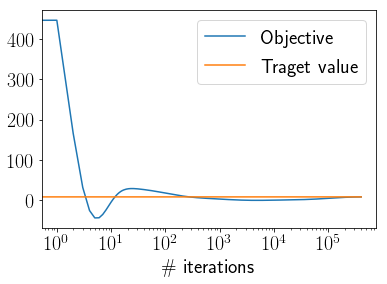

In [13]:
plt.plot([f(x) for x in conv_x_da], label="Objective")
plt.plot(problem.value * np.ones(len(conv_x_da)), label="Traget value")
# plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=20)
plt.xlabel("\# iterations", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

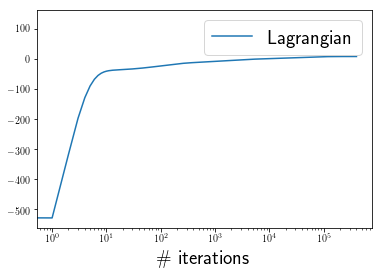

In [15]:
plt.plot([L(x, lam) for x, lam in zip(conv_x_da, conv_lam_da)], 
         label="Lagrangian")
plt.legend(fontsize=20)
plt.xlabel("\# iterations", fontsize=20)
plt.xscale("log")

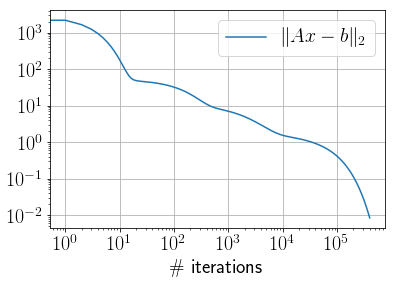

In [17]:
plt.semilogy([np.linalg.norm(A @ x - b) for x in conv_x_da], label="$\|Ax - b\|_2$")
plt.legend(fontsize=20)
plt.xlabel("\# iterations", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.xscale("log")

### Важный частный случай

- Функция сепарабельна
- Обновление $x$ распадается на параллельные задачи по каждой координате

## Явный учёт наличия ограничений - регуляризация Лагранжиана

$$
L_{\rho}(x, \lambda) = f(x) + \lambda^{\top}(Ax - b) + \frac{\rho}{2} \|Ax - b\|_2^2
$$

- Теперь метод примет вид

\begin{align*}
& x_{k+1} = \arg\min_x L_{\rho}(x, \lambda_k)\\
& \lambda_{k+1} = \lambda_k + \rho (Ax_{k+1} - b)
\end{align*}

- Возможны изменения $\rho$ в процессе сходимости
- Замена $\alpha_k$ на $\rho$ связаны с условиями оптимальности

In [18]:
def augmented_lagrangian(update_x, A, b, rho0, x0, lambda0, max_iter):
    x = x0.copy()
    lam = lambda0.copy()
    conv_x = [x]
    conv_lam = [lam]
    rho = rho0
    for i in range(max_iter):
        x = update_x(x, lam, A, b)
        lam = lam + rho * (A @ x - b)
        conv_x.append(x.copy())
        conv_lam.append(lam.copy())
    return x, lam, conv_x, conv_lam

In [31]:
def update_x_al(x, lam, A, b):
    return np.linalg.solve(P + rho * A.T @ A, c - A.T @ lam + A.T @ b)

rho = 1000
max_iter = 10
x_al, lam_al, conv_x_al, conv_lam_al = augmented_lagrangian(update_x_al, A, b, rho, x0, lam0, max_iter)
print(np.linalg.norm(A @ x_al - b))
print(0.5 * x_al @ P @ x_al - c @ x_al - problem.value)

6.60471901297632e-16
0.0


Text(0, 0.5, 'Objective')

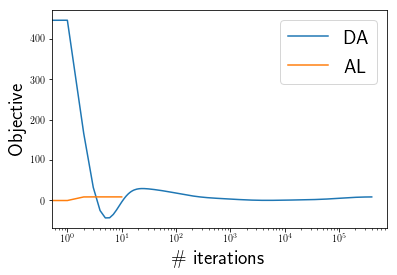

In [32]:
plt.plot([f(x) for x in conv_x_da], label="DA")
plt.plot([f(x) for x in conv_x_al], label="AL")
# plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=20)
plt.xlabel("\# iterations", fontsize=20)
plt.ylabel("Objective", fontsize=20)

Text(0.5, 0, 'Lagrangian')

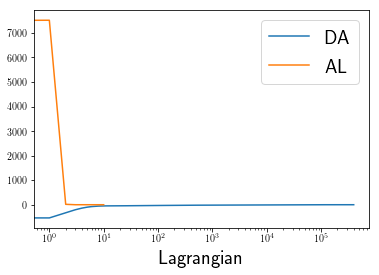

In [33]:
plt.plot([L(x, lam) for x, lam in zip(conv_x_da, conv_lam_da)], 
         label="DA")
plt.plot([L(x, lam) for x, lam in zip(conv_x_al, conv_lam_al)], 
         label="AL")
plt.legend(fontsize=20)
plt.xscale("log")
plt.xlabel("\# iterations", fontsize=20)
plt.xlabel("Lagrangian", fontsize=20)

(array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06, 1.e+07]), <a list of 10 Text xticklabel objects>)

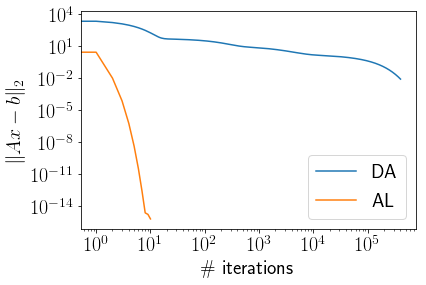

In [34]:
plt.semilogy([np.linalg.norm(A @ x - b) for x in conv_x_da], label="DA")
plt.semilogy([np.linalg.norm(A @ x - b) for x in conv_x_al], label="AL")
plt.legend(fontsize=20)
plt.xscale("log")
plt.xlabel("\# iterations", fontsize=20)
plt.ylabel("$\|Ax - b\|_2$", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

### Существенная проблема

- Слагаемое $\|Ax - b\|_2^2$ сделало лагранжиан НЕсепарабельным!

## Сделаем его сепарабельным и получим ADMM

Задача станет такой

\begin{align*}
& \min f(x) + I_{Ax = b} (z)\\
\text{s.t. } & x = z
\end{align*}

Для неё модифицированный лагранжиан примет вид

$$
L_{\rho}(x, z, \lambda) = f(x) + I_{Ax = b} (z) + \lambda^{\top}(x - z) + \frac{\rho}{2}\|x - z\|_2^2
$$

- Теперь метод примет вид

\begin{align*}
& x_{k+1} = \arg\min_x L_{\rho}(x, z_k, \lambda_k)\\
& z_{k+1} = \arg\min_z L_{\rho}(x_{k+1}, z, \lambda_k) \\
& \lambda_{k+1} = \lambda_k + \rho (x_{k+1} - z_{k+1})
\end{align*}
- Обновление $z$ эквивалентно $\pi_{Ax = b}(x_{k+1} + \frac{\lambda_k}{\rho})$ 

In [35]:
def admm(update_x, update_z, rho0, x0, z0, lambda0, max_iter):
    x = x0.copy()
    z = z0.copy()
    lam = lambda0.copy()
    conv_x = [x]
    conv_z = [z]
    conv_lam = [lam]
    rho = rho0
    for i in range(max_iter):
        x = update_x(x, z, lam, A, b)
        z = update_z(x, z, lam, A, b)
        lam = lam + rho * (x - z)
        conv_x.append(x.copy())
        conv_z.append(z.copy())
        conv_lam.append(lam.copy())
    return x, z, lam, conv_x, conv_z, conv_lam

In [36]:
def update_x_admm(x, z, lam, A, b):
    n = x.shape[0]
    return np.linalg.solve(P + rho*np.eye(n), -lam + c + rho * z)

def update_z_admm(x, z, lam, A, b):
    x_hat = lam / rho + x
    return x_hat - A.T @ np.linalg.solve(A @ A.T, A @ x_hat - b)

In [59]:
z0 = np.random.randn(n)
lam0 = np.random.randn(n)
rho = 10
maxiter = 50
x_admm, z_admm, lam_admm, conv_x_admm, conv_z_admm, conv_lam_admm = admm(update_x_admm, 
                                                                         update_z_admm, 
                                                                         rho, x0, z0, lam0, 
                                                                         max_iter=maxiter)
print(np.linalg.norm(x_admm - z_admm))
print(np.linalg.norm(A @ x_admm - b))
print(0.5 * x_admm @ P @ x_admm - c @ x_admm - problem.value)

2.9654436872276462e-06
1.3500286692570037e-05
-1.9610705576766918e-05


(array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06, 1.e+07]), <a list of 10 Text xticklabel objects>)

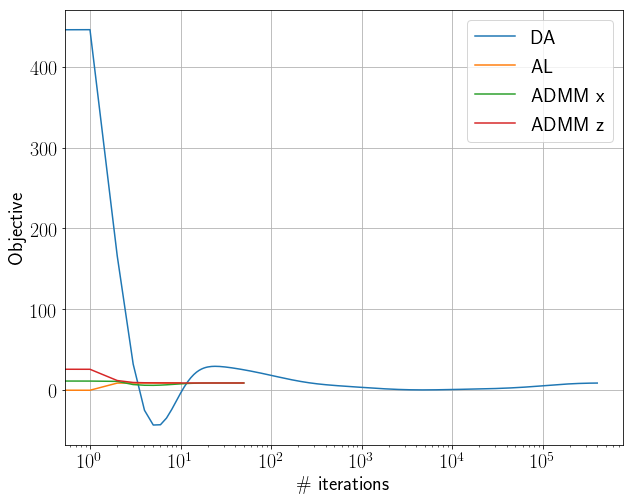

In [60]:
plt.figure(figsize=(10, 8))
plt.plot([f(x) for x in conv_x_da], label="DA")
plt.plot([f(x) for x in conv_x_al], label="AL")
plt.plot([f(x) for x in conv_x_admm], label="ADMM x")
plt.plot([f(z) for z in conv_z_admm], label="ADMM z")
# plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=20)
plt.xlabel("\# iterations", fontsize=20)
plt.ylabel("Objective", fontsize=20)
plt.grid(True)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

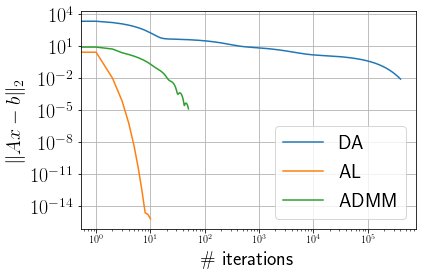

In [61]:
plt.semilogy([np.linalg.norm(A @ x - b) for x in conv_x_da], label="DA")
plt.semilogy([np.linalg.norm(A @ x - b) for x in conv_x_al], label="AL")
plt.semilogy([np.linalg.norm(A @ x - b) for x in conv_x_admm], label="ADMM")
plt.legend(fontsize=20)
plt.xscale("log")
plt.xlabel("\# iterations", fontsize=20)
plt.ylabel("$\|Ax - b\|_2$", fontsize=20)
plt.grid(True)
plt.yticks(fontsize=20)
plt.show()

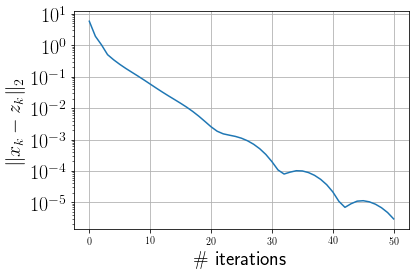

In [62]:
plt.semilogy([np.linalg.norm(x - z) for x, z in zip(conv_x_admm, conv_z_admm)])
plt.grid(True)
plt.xlabel("\# iterations", fontsize=20)
plt.ylabel("$\|x_k - z_k\|_2$", fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### Учтём, что все свойства сохранятся при аффинных преобразованиях

- Тогда наша задача в общем виде может быть записана как

\begin{align*}
& \min f(x) + g(z)\\
\text{s.t. } & Ax + Bz = d
\end{align*}

- Модифицированный лагранжиан для неё будет

$$
L_{\rho}(x, z, \lambda) = f(x) + g(z) + \lambda^{\top}(Ax + Bz - d) + \frac{\rho}{2}\|Ax + Bz - d\|_2^2
$$
- В этом случае сепарабельность по $z$ и $x$, но не внутри этих переменных
- В итоге, после внесения линейного слагаемого в квадратичное получим

\begin{align*}
& x_{k+1} = \arg\min_x \left( f(x) + \frac{\rho}{2}\|Ax + Bz_k - d + u_k \|_2^2 \right)\\
& z_{k+1} = \arg\min_z  \left( g(z) + \frac{\rho}{2}\|Ax_{k+1} + Bz - d + u_k \|_2^2 \right)\\
& u_{k+1} = u_k + x_{k+1} - z_{k+1},
\end{align*}
где $u_k = \lambda_k / \rho$

### Как это всё использовать?

- Часто приводить вашу задачу к стандартному виду с предыдущего слайда неудобно
- Поэтому лучше для конкретной задачи приводить её руками к виду, который допускает применение ADMM
- Выписать аналитически все решения вспомогательных задач
- Реализовать их вычисления наиболее оптимальным образом (сделать факторизации матриц, которые не меняются с итерациями)

## Задача линейного программирования

\begin{align*}
& \min c^{\top}x\\
\text{s.t. } & Ax = b\\
& x \geq 0
\end{align*}

- Модифицированный лагранжиан

$$
L_{\rho}(x, z, \lambda) = c^{\top}x + I_{z \geq 0}(z) + \lambda^{\top}(x - z) + \frac{\rho}{2}\|x - z\|_2^2,
$$

где $c^{\top}x$ определена на множестве $Ax = b$.

- Шаг обновления по $x$ примет вид

$$
x_{k+1} = \arg\min_{x: \; Ax = b} c^{\top}x +\lambda_k^{\top}x + \frac{\rho}{2}\|x - z_k\|_2^2
$$

- Получим систему из условий оптимальности

$$
\begin{bmatrix}
\rho I & A^{\top} \\
A & 0
\end{bmatrix}
\begin{bmatrix}
x_{k+1}\\
\mu
\end{bmatrix}
= 
\begin{bmatrix}
-\lambda_k - c + \rho z_k\\
b
\end{bmatrix}
$$

In [76]:
import scipy.optimize as scopt

m, n = 10, 200
A = np.random.rand(m, n)
b = np.random.rand(m)
c = np.random.rand(n)

scipy_linprog_conv = []
def callback_splin(cur_res):
    scipy_linprog_conv.append(cur_res)
    
res = scopt.linprog(c, A_eq=A, b_eq=b, 
                    bounds=[(0, None) for i in range(n)],
                    callback=callback_splin, method="simplex")
print(res)

     con: array([ 1.11022302e-16,  5.55111512e-16,  1.11022302e-16,  0.00000000e+00,
        4.44089210e-16,  0.00000000e+00,  2.22044605e-16,  1.11022302e-16,
       -1.11022302e-16, -1.11022302e-16])
     fun: 0.1655703224160603
 message: 'Optimization terminated successfully.'
     nit: 28
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 

In [77]:
def update_x_admm(x, z, lam, A, b):
    n = x.shape[0]
    m = A.shape[0]
    C = np.block([[rho * np.eye(n), A.T], [A, np.zeros((m, m))]])
    rhs = np.block([-lam - c + rho * z, b])
    return np.linalg.solve(C, rhs)[:n]

def update_z_admm(x, z, lam, A, b):
    x_hat = lam / rho + x
    return np.clip(x_hat, 0, np.max(x_hat))

In [90]:
x0 = np.random.randn(n)
z0 = np.random.randn(n)
lam0 = np.random.randn(n)
rho = 1
max_iter = 100

x_admm, z_admm, lam_admm, conv_x_admm, conv_z_admm, conv_lam_admm = admm(update_x_admm, 
                                                                         update_z_admm, 
                                                                         rho, x0, z0, lam0,
                                                                         max_iter=max_iter)
print(res.fun - c @ x_admm)

-0.004469552138337579


In [91]:
print(c @ x_admm - res.fun, np.linalg.norm(x_admm - res.x))

0.004469552138337579 0.3102567257353814


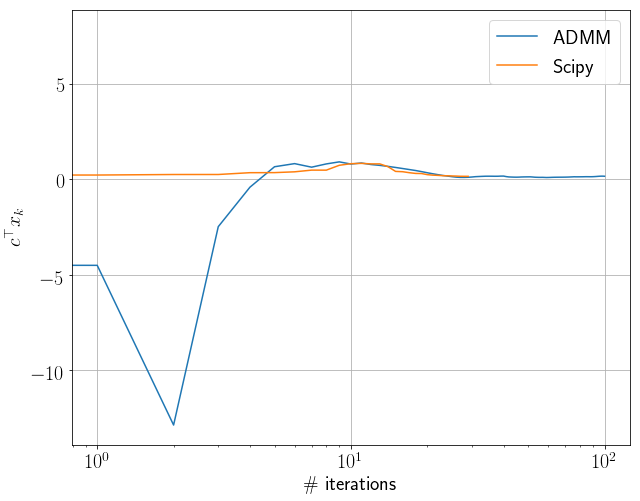

In [92]:
plt.figure(figsize=(10, 8))
plt.plot([c @ x for x in conv_x_admm], label="ADMM")
plt.plot([c @ res.x for res in scipy_linprog_conv], label="Scipy")
plt.legend(fontsize=20)
plt.grid(True)
plt.xlabel("\# iterations", fontsize=20)
plt.ylabel("$c^{\\top}x_k$", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xscale("log")

## Комментарии

- Сходимость по итерациям медленнее, но стоимость одной итерации также меньше
- Основной выигрыш при использовании ADMM в получении не очень точного решения **параллельно** и очень быстро
- Различные способы представления задачи в виде, пригодном для использования ADMM, порождают различные методы, которые имеют различные свойства
- Например в [этой](https://papers.nips.cc/paper/6746-a-new-alternating-direction-method-for-linear-programming.pdf) статье предлагается альтернативный способ решения задачи линейного программирования через ADMM
- [Метод SCS](https://stanford.edu/~boyd/papers/pdf/scs_long.pdf), используемый по умолчанию в CVXPy, основан на применении ADMM к коническому представлению исходной задачи 